# Healthcare NER Fine-tuning Pipeline
## NCBI Disease (EN) + Quaero French Med (FR)

**Setup:** Runtime → Change runtime type → T4 GPU → Save

In [6]:
# Install dependencies
!pip install -q datasets accelerate seqeval scikit-learn
!pip install torch torchvision
!pip install transformers
!pip install spacy
!pip install spacy-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 756.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 6.8 MB/s eta 0:00:00


In [1]:
# Imports
import torch
from datasets import load_dataset, concatenate_datasets, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
from collections import Counter

print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
Device: Tesla T4
Memory: 15.83 GB


### Load Dataset

In [10]:
!wget -O quaero.zip https://quaerofrenchmed.limsi.fr/QUAERO_FrenchMed_brat.zip
!unzip -o quaero.zip -d quaero_data


Streaming output truncated to the last 5000 lines.
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1211745.ann  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1211745.ann~  
 extracting: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1211745.txt  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12124528.ann  
 extracting: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12124528.txt  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12143848.ann  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12143848.txt  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12146146.ann  
 extracting: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/12146146.txt  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1215988.ann  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1215988.txt  
  inflating: quaero_data/QUAERO_FrenchMed/corpus/dev/MEDLINE/1217891.ann  
  inflating: quaero_data/QUAERO_FrenchMed/

In [11]:
!wget https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/NCBI_corpus.zip -O ncbi_disease.zip
!unzip -o ncbi_disease.zip -d ncbi_disease


--2026-01-26 13:52:49--  https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/NCBI_corpus.zip
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368345 (360K) [application/zip]
Saving to: ‘ncbi_disease.zip’

ncbi_disease.zip    100%[===================>] 359.71K  1.26MB/s    in 0.3s    

2026-01-26 13:52:50 (1.26 MB/s) - ‘ncbi_disease.zip’ saved [368345/368345]

Archive:  ncbi_disease.zip
  inflating: ncbi_disease/NCBI_corpus_development.txt  
  inflating: ncbi_disease/NCBI_corpus_testing.txt  
  inflating: ncbi_disease/NCBI_corpus_training.txt  


### COMPLETE DATA LOADING & PREPROCESSING

In [12]:
import re
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
## Note: AI Generated, Coudn't find the HF dataset
# 1. PARSE NCBI DISEASE (English) - XML tag format


def parse_ncbi_with_tags(filepath):
    """Parse NCBI format: PMID\ttext with <category="type">entity</category> tags"""
    examples = []

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split('\t', 1)
            if len(parts) < 2:
                continue

            pmid = parts[0]
            text_with_tags = parts[1]

            # Pattern: <category="Type">entity text</category>
            pattern = r'<category="[^"]*">([^<]+)</category>'

            # Extract entities with positions
            entities = []
            for match in re.finditer(pattern, text_with_tags):
                entity_text = match.group(1)
                start_in_tagged = match.start()
                entities.append((start_in_tagged, entity_text))

            # Remove all tags to get clean text
            clean_text = re.sub(r'<category="[^"]*">', '', text_with_tags)
            clean_text = re.sub(r'</category>', '', clean_text)

            # Tokenize
            tokens = clean_text.split()
            tags = ['O'] * len(tokens)

            # Map character positions to token indices
            char_to_token = {}
            char_pos = 0
            for token_idx, token in enumerate(tokens):
                for i in range(len(token)):
                    char_to_token[char_pos + i] = token_idx
                char_pos += len(token) + 1

            # Mark entities in BIO format
            for entity_start_tagged, entity_text in entities:
                text_before = text_with_tags[:entity_start_tagged]
                clean_before = re.sub(r'<category="[^"]*">', '', text_before)
                clean_before = re.sub(r'</category>', '', clean_before)
                start_pos = len(clean_before)
                end_pos = start_pos + len(entity_text)

                start_token = char_to_token.get(start_pos)
                end_token = char_to_token.get(end_pos - 1)

                if start_token is not None:
                    tags[start_token] = 'B-Disease'
                    if end_token is not None and end_token > start_token:
                        for i in range(start_token + 1, min(end_token + 1, len(tags))):
                            tags[i] = 'I-Disease'

            if tokens:
                examples.append({'tokens': tokens, 'ner_tags': tags})

    return examples

print("Parsing NCBI Disease corpus...")
ncbi_train_data = parse_ncbi_with_tags('/content/ncbi_disease/NCBI_corpus_training.txt')
ncbi_test_data = parse_ncbi_with_tags('/content/ncbi_disease/NCBI_corpus_testing.txt')
print(f"✓ NCBI Train: {len(ncbi_train_data)} examples")
print(f"✓ NCBI Test: {len(ncbi_test_data)} examples")

# ----------------------------------------------------------------------------
# 2. PARSE QUAERO (French) - BRAT format with DISO entities
# ----------------------------------------------------------------------------

def parse_brat_folder_correct(folder_path):
    """Parse BRAT - extract DISO (disorder) entities only"""
    examples = []

    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    for txt_file in txt_files:
        txt_path = os.path.join(folder_path, txt_file)
        ann_path = os.path.join(folder_path, txt_file.replace('.txt', '.ann'))

        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # Tokenize preserving character positions
        tokens = []
        token_spans = []
        for match in re.finditer(r"\S+", text):
            tokens.append(match.group())
            token_spans.append((match.start(), match.end()))

        tags = ['O'] * len(tokens)

        # Read annotations - ONLY DISO entities
        if os.path.exists(ann_path):
            with open(ann_path, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith('T'):
                        parts = line.strip().split('\t')
                        if len(parts) >= 2:
                            ann_info = parts[1].split()
                            if len(ann_info) >= 3:
                                entity_type = ann_info[0]

                                if entity_type == 'DISO':
                                    try:
                                        start = int(ann_info[1])
                                        end_str = ann_info[2].split(';')[0]
                                        end = int(end_str)

                                        # Tag tokens in this span
                                        first_token = True
                                        for token_idx, (tok_start, tok_end) in enumerate(token_spans):
                                            if tok_start < end and tok_end > start:
                                                if first_token:
                                                    tags[token_idx] = 'B-Disease'
                                                    first_token = False
                                                else:
                                                    tags[token_idx] = 'I-Disease'
                                    except (ValueError, IndexError):
                                        continue

        if tokens:
            examples.append({'tokens': tokens, 'ner_tags': tags})

    return examples

print("\nParsing Quaero corpus...")
quaero_emea = parse_brat_folder_correct('/content/quaero_data/QUAERO_FrenchMed/corpus/train/EMEA')
quaero_medline = parse_brat_folder_correct('/content/quaero_data/QUAERO_FrenchMed/corpus/train/MEDLINE')
quaero_all = quaero_emea + quaero_medline
print(f"✓ Quaero Total: {len(quaero_all)} examples")

# Split 80/20
quaero_train_data, quaero_test_data = train_test_split(quaero_all, test_size=0.2, random_state=42)
print(f"✓ Quaero Train: {len(quaero_train_data)}, Test: {len(quaero_test_data)}")

# 3. CONVERT TO HUGGINGFACE DATASETS

label_list = ['O', 'B-Disease', 'I-Disease']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

label_mapping_ncbi = {
    0: 0,  # O → O
    1: 1,  # B-Disease → B-Disease
    2: 2,  # I-Disease → I-Disease
}

# Example for Quaero (MODIFY THIS based on actual labels):
# If Quaero has: ['O', 'B-DISORDER', 'I-DISORDER', 'B-ANATOMY', 'I-ANATOMY']
label_mapping_quaero = {
    0: 0,  # O → O
    1: 1,  # B-DISORDER → B-Disease
    2: 2,  # I-DISORDER → I-Disease
    3: 0,  # B-ANATOMY → O (ignore)
    4: 0,  # I-ANATOMY → O (ignore)
    # Add more mappings as needed based on actual labels
}


def convert_tags_to_ids(examples):
    """Convert string BIO tags to numeric IDs"""
    for example in examples:
        example['ner_tags'] = [label2id[tag] for tag in example['ner_tags']]
    return examples

ncbi_train_data = convert_tags_to_ids(ncbi_train_data)
ncbi_test_data = convert_tags_to_ids(ncbi_test_data)
quaero_train_data = convert_tags_to_ids(quaero_train_data)
quaero_test_data = convert_tags_to_ids(quaero_test_data)

# Create HF Datasets
ncbi = DatasetDict({
    'train': Dataset.from_dict({
        'tokens': [ex['tokens'] for ex in ncbi_train_data],
        'ner_tags': [ex['ner_tags'] for ex in ncbi_train_data]
    }),
    'test': Dataset.from_dict({
        'tokens': [ex['tokens'] for ex in ncbi_test_data],
        'ner_tags': [ex['ner_tags'] for ex in ncbi_test_data]
    })
})

quaero = DatasetDict({
    'train': Dataset.from_dict({
        'tokens': [ex['tokens'] for ex in quaero_train_data],
        'ner_tags': [ex['ner_tags'] for ex in quaero_train_data]
    }),
    'test': Dataset.from_dict({
        'tokens': [ex['tokens'] for ex in quaero_test_data],
        'ner_tags': [ex['ner_tags'] for ex in quaero_test_data]
    })
})
# 4. VERIFICATION

print("\n" + "="*70)
print("DATASETS READY!")
print("="*70)
print(f"NCBI: {ncbi}")
print(f"Quaero: {quaero}")
print(f"\nLabel schema: {label_list}")
print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

# Entity counts
ncbi_entities = sum(1 for ex in ncbi['train'] for tag in ex['ner_tags'] if tag == 1)
quaero_entities = sum(1 for ex in quaero['train'] for tag in ex['ner_tags'] if tag == 1)
print(f"\nNCBI train entities: {ncbi_entities}")
print(f"Quaero train entities: {quaero_entities}")

print("\n✅ Ready to proceed to Cell 4 (Model Setup)")

Parsing NCBI Disease corpus...
✓ NCBI Train: 593 examples
✓ NCBI Test: 100 examples

Parsing Quaero corpus...
✓ Quaero Total: 844 examples
✓ Quaero Train: 675, Test: 169

DATASETS READY!
NCBI: DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 593
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})
Quaero: DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 675
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 169
    })
})

Label schema: ['O', 'B-Disease', 'I-Disease']
label2id: {'O': 0, 'B-Disease': 1, 'I-Disease': 2}
id2label: {0: 'O', 1: 'B-Disease', 2: 'I-Disease'}

NCBI train entities: 5130
Quaero train entities: 1024

✅ Ready to proceed to Cell 4 (Model Setup)


## 4. Model & Tokenizer Setup

In [6]:
# Using XLM-RoBERTa-base (better multilingual than mBERT)
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"✓ Loaded tokenizer: {model_name}")
print(f"Vocab size: {len(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

✓ Loaded tokenizer: xlm-roberta-base
Vocab size: 250002


## 5. Tokenization & Label Alignment

In [7]:
# Taken from https://huggingface.co/docs/transformers/tasks/token_classification


def tokenize_and_align(examples, label_mapping):
    """
    Tokenize text and align labels to subword tokens.
    Args:
        examples: Batch of examples with 'tokens' and 'ner_tags'
        label_mapping: Dict mapping original labels to unified schema
    """
    tokenized = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
        padding=False  # Data collator handles padding
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (CLS, SEP, PAD) → ignore in loss
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword token of a word → use mapped label
                orig_label = label[word_idx]
                mapped_label = label_mapping.get(orig_label, 0)  # Default to O
                label_ids.append(mapped_label)
            else:
                # Continuation of subword tokens → ignore in loss
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized["labels"] = labels
    return tokenized

print("✓ Tokenization function defined")

✓ Tokenization function defined


## 6. Prepare Training Data

In [8]:
# Sample 500 from each (with shuffling for diversity)
ncbi_train_sample = ncbi['train'].shuffle(seed=42).select(range(min(500, len(ncbi['train']))))
quaero_train_sample = quaero['train'].shuffle(seed=42).select(range(min(500, len(quaero['train']))))

print(f"Sampled {len(ncbi_train_sample)} English (NCBI) examples")
print(f"Sampled {len(quaero_train_sample)} French (Quaero) examples")

# Tokenize with dataset-specific label mappings
print("\nTokenizing NCBI dataset...")
ncbi_tokenized = ncbi_train_sample.map(
    lambda x: tokenize_and_align(x, label_mapping_ncbi),
    batched=True,
    remove_columns=ncbi_train_sample.column_names
)

print("Tokenizing Quaero dataset...")
quaero_tokenized = quaero_train_sample.map(
    lambda x: tokenize_and_align(x, label_mapping_quaero),
    batched=True,
    remove_columns=quaero_train_sample.column_names
)

# Combine and shuffle
train_dataset = concatenate_datasets([ncbi_tokenized, quaero_tokenized]).shuffle(seed=42)
print(f"\n✓ Combined training set: {len(train_dataset)} samples")

# Prepare test sets (keep separate by language)
print("\nPreparing test sets...")
ncbi_test = ncbi['test'].map(
    lambda x: tokenize_and_align(x, label_mapping_ncbi),
    batched=True,
    remove_columns=ncbi['test'].column_names
)

# Handle different split names for Quaero
if 'test' in quaero:
    quaero_test = quaero['test'].map(
        lambda x: tokenize_and_align(x, label_mapping_quaero),
        batched=True,
        remove_columns=quaero['test'].column_names
    )
elif 'validation' in quaero:
    quaero_test = quaero['validation'].map(
        lambda x: tokenize_and_align(x, label_mapping_quaero),
        batched=True,
        remove_columns=quaero['validation'].column_names
    )

print(f"✓ Test sets ready: EN={len(ncbi_test)}, FR={len(quaero_test)}")

Sampled 500 English (NCBI) examples
Sampled 500 French (Quaero) examples

Tokenizing NCBI dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing Quaero dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


✓ Combined training set: 1000 samples

Preparing test sets...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

✓ Test sets ready: EN=100, FR=169


## 7. Initialize Model

In [9]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # New classification head
)

print(f"✓ Model initialized: {model_name}")
print(f"   Labels: {len(label_list)}")
print(f"   Parameters: {model.num_parameters() / 1e6:.1f}M")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model initialized: xlm-roberta-base
   Labels: 3
   Parameters: 277.5M


## 8. Define Evaluation Metrics

In [10]:
def compute_metrics(pred):
    """
    Compute token-level F1, Precision, Recall using seqeval.
    """
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)

    # Convert IDs to labels, filtering out ignored tokens (-100)
    true_labels = [
        [id2label[l] for l in label if l != -100]
        for label in labels
    ]
    true_preds = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return {
        "f1": f1_score(true_labels, true_preds),
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds)
    }

print("✓ Metrics function ready")

✓ Metrics function ready


## 9. Training Configuration

In [11]:

# TRAINING CONFIGURATION


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    push_to_hub=False,
    report_to="none"  # Disable wandb/tensorboard
)

data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=ncbi_test,  # Evaluate on English during training
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✓ Trainer initialized")
print(f"   Total training steps: {len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

/tmp/ipython-input-67016174.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✓ Trainer initialized
   Total training steps: 186


## 10. Train Model

In [12]:
print("Starting training...\n")
print("="*70)
train_result = trainer.train()
print("="*70)
print("\n✓ Training complete!")
print(f"Training time: {train_result.metrics['train_runtime']:.2f}s")

Starting training...



Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.625600,0.178080,0.000000,0.000000,0.000000
2,0.176300,0.071156,0.747673,0.691123,0.814301
3,0.079100,0.062864,0.769777,0.733333,0.810032


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



✓ Training complete!
Training time: 274.80s


## 11. Evaluate on Both Languages

In [13]:
print("\n" + "="*70)
print("ENGLISH (NCBI) TEST SET EVALUATION")
print("="*70)
ncbi_results = trainer.evaluate(ncbi_test)
print(f"\nF1 Score:  {ncbi_results['eval_f1']:.4f}")
print(f"Precision: {ncbi_results['eval_precision']:.4f}")
print(f"Recall:    {ncbi_results['eval_recall']:.4f}")


ENGLISH (NCBI) TEST SET EVALUATION



F1 Score:  0.7698
Precision: 0.7333
Recall:    0.8100


In [14]:
print("\n" + "="*70)
print("FRENCH (QUAERO) TEST SET EVALUATION")
print("="*70)
quaero_results = trainer.evaluate(quaero_test)
print(f"\nF1 Score:  {quaero_results['eval_f1']:.4f}")
print(f"Precision: {quaero_results['eval_precision']:.4f}")
print(f"Recall:    {quaero_results['eval_recall']:.4f}")


FRENCH (QUAERO) TEST SET EVALUATION



F1 Score:  0.4867
Precision: 0.5075
Recall:    0.4676


## 12. Detailed Per-Entity Type Reports

In [15]:
# English detailed report
print("\n" + "="*70)
print("ENGLISH - PER ENTITY TYPE CLASSIFICATION REPORT")
print("="*70)

predictions_ncbi = trainer.predict(ncbi_test)
preds_ncbi = np.argmax(predictions_ncbi.predictions, axis=2)
labels_ncbi = predictions_ncbi.label_ids

true_labels_ncbi = [
    [id2label[l] for l in label if l != -100]
    for label in labels_ncbi
]
true_preds_ncbi = [
    [id2label[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds_ncbi, labels_ncbi)
]

print(classification_report(true_labels_ncbi, true_preds_ncbi, digits=4))


ENGLISH - PER ENTITY TYPE CLASSIFICATION REPORT


              precision    recall  f1-score   support

     Disease     0.7333    0.8100    0.7698       937

   micro avg     0.7333    0.8100    0.7698       937
   macro avg     0.7333    0.8100    0.7698       937
weighted avg     0.7333    0.8100    0.7698       937



In [16]:
# French detailed report
print("\n" + "="*70)
print("FRENCH - PER ENTITY TYPE CLASSIFICATION REPORT")
print("="*70)

predictions_quaero = trainer.predict(quaero_test)
preds_quaero = np.argmax(predictions_quaero.predictions, axis=2)
labels_quaero = predictions_quaero.label_ids

true_labels_quaero = [
    [id2label[l] for l in label if l != -100]
    for label in labels_quaero
]
true_preds_quaero = [
    [id2label[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds_quaero, labels_quaero)
]

print(classification_report(true_labels_quaero, true_preds_quaero, digits=4))


FRENCH - PER ENTITY TYPE CLASSIFICATION REPORT


              precision    recall  f1-score   support

     Disease     0.5075    0.4676    0.4867       216

   micro avg     0.5075    0.4676    0.4867       216
   macro avg     0.5075    0.4676    0.4867       216
weighted avg     0.5075    0.4676    0.4867       216



## 13. Cross-Lingual Transfer Analysis (Zero-Shot)

Train on English only → Test on French (no French training data)

In [17]:
print("\n" + "="*70)
print("ZERO-SHOT CROSS-LINGUAL TRANSFER: EN → FR")
print("="*70)

# Train new model on English only
model_zeroshot = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

trainer_zeroshot = Trainer(
    model=model_zeroshot,
    args=training_args,
    train_dataset=ncbi_tokenized,  # English only!
    eval_dataset=ncbi_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Training on English only...")
trainer_zeroshot.train()

print("\nTesting on French (zero-shot)...")
zeroshot_results = trainer_zeroshot.evaluate(quaero_test)
print(f"\nZero-shot FR F1:  {zeroshot_results['eval_f1']:.4f}")
print(f"Zero-shot FR Precision: {zeroshot_results['eval_precision']:.4f}")
print(f"Zero-shot FR Recall:    {zeroshot_results['eval_recall']:.4f}")

# Compare with bilingual model
print("\n" + "="*70)
print("COMPARISON: Bilingual vs Zero-Shot on French")
print("="*70)
print(f"Bilingual model (EN+FR training): F1 = {quaero_results['eval_f1']:.4f}")
print(f"Zero-shot model (EN only):         F1 = {zeroshot_results['eval_f1']:.4f}")
print(f"Improvement from FR training:      {(quaero_results['eval_f1'] - zeroshot_results['eval_f1']):.4f}")


ZERO-SHOT CROSS-LINGUAL TRANSFER: EN → FR


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3025945868.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_zeroshot = Trainer(


Training on English only...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,No log,0.589640,0.000000,0.000000,0.000000
2,0.714800,0.182800,0.000000,0.000000,0.000000
3,0.714800,0.086063,0.674123,0.643689,0.707577


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing on French (zero-shot)...



Zero-shot FR F1:  0.3432
Zero-shot FR Precision: 0.3164
Zero-shot FR Recall:    0.3750

COMPARISON: Bilingual vs Zero-Shot on French
Bilingual model (EN+FR training): F1 = 0.4867
Zero-shot model (EN only):         F1 = 0.3432
Improvement from FR training:      0.1435


## 14. Save Model & Results

In [18]:
# Save best model
output_dir = "/content/trained_ner_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✓ Model saved to {output_dir}")

# Save results summary
import json

results_summary = {
    "model": model_name,
    "training_samples": len(train_dataset),
    "english_train": len(ncbi_tokenized),
    "french_train": len(quaero_tokenized),
    "label_schema": label_list,
    "results": {
        "english_test": {
            "f1": ncbi_results['eval_f1'],
            "precision": ncbi_results['eval_precision'],
            "recall": ncbi_results['eval_recall']
        },
        "french_test": {
            "f1": quaero_results['eval_f1'],
            "precision": quaero_results['eval_precision'],
            "recall": quaero_results['eval_recall']
        },
        "zero_shot_french": {
            "f1": zeroshot_results['eval_f1'],
            "precision": zeroshot_results['eval_precision'],
            "recall": zeroshot_results['eval_recall']
        }
    }
}

with open(f"{output_dir}/results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results summary saved")
print("\n📁 To download: Files → right-click 'multilingual_disease_ner' → Download")

✓ Model saved to /content/trained_ner_model
✓ Results summary saved

📁 To download: Files → right-click 'multilingual_disease_ner' → Download


In [19]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Save model
import shutil
import os

drive_model_path = "/content/drive/MyDrive/NeuroKnow_Models/healthcare_ner"
os.makedirs(drive_model_path, exist_ok=True)
shutil.copytree("/content/trained_ner_model", drive_model_path, dirs_exist_ok=True)

print(f"✓ Model saved to: {drive_model_path}")

Mounted at /content/drive
✓ Model saved to: /content/drive/MyDrive/NeuroKnow_Models/healthcare_ner


## 15. Example Predictions

In [20]:
# Test on custom examples
def predict_entities(text, lang="en"):
    """Predict entities in a text string"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Extract entities
    entities = []
    current_entity = []
    current_label = None

    for token, pred in zip(tokens, predictions[0]):
        label = id2label[pred.item()]

        if token in ["<s>", "</s>", "<pad>"]:
            continue

        if label.startswith("B-"):
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity = [token]
            current_label = label[2:]
        elif label.startswith("I-") and current_label:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
            current_entity = []
            current_label = None

    if current_entity:
        entities.append((" ".join(current_entity), current_label))

    return entities

# Test examples
print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

en_example = "The patient was diagnosed with hypertension and diabetes mellitus."
fr_example = "Le patient souffre d'hypertension et de diabète de type 2."

print(f"\nEnglish: {en_example}")
en_entities = predict_entities(en_example, "en")
print(f"Entities: {en_entities}")

print(f"\nFrench: {fr_example}")
fr_entities = predict_entities(fr_example, "fr")
print(f"Entities: {fr_entities}")


EXAMPLE PREDICTIONS

English: The patient was diagnosed with hypertension and diabetes mellitus.
Entities: [('▁hyper', 'Disease'), ('tension', 'Disease'), ('▁diabetes ▁mell itus', 'Disease')]

French: Le patient souffre d'hypertension et de diabète de type 2.
Entities: [('hy', 'Disease'), ('per tension', 'Disease'), ('▁di', 'Disease'), ('ab ète ▁de ▁type ▁2.', 'Disease')]


# Part B

In [53]:
!pip install -U spacy spacy-transformers torch
!python -m spacy download en_core_web_sm
!pip install -q spacy scikit-learn matplotlib seaborn
!python -m spacy download en_core_web_lg
!pip install -U spacy spacy-transformers torch
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 136.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

✘ No compatible package found for 'en_legal_ner_trf' (spaCy
v3.8.11)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [1]:
!pip install -U spacy spacy-transformers torch

!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
### Cell 2: Imports for Part B

In [28]:
import spacy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Loading NER models...")
import torch
# Healthcare NER (from Google Drive)
from google.colab import drive
drive.mount('/content/drive')

drive_model_path = "/content/drive/MyDrive/NeuroKnow_Models/healthcare_ner"
healthcare_tokenizer = AutoTokenizer.from_pretrained(drive_model_path)
healthcare_model = AutoModelForTokenClassification.from_pretrained(drive_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
healthcare_model = healthcare_model.to(device)
healthcare_model.eval()



Loading NER models...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768

In [3]:
# Legal & Finance - Use transformer model
import spacy

general_nlp = spacy.load("en_core_web_trf")

print(" All NER models loaded")
print(f"  - Healthcare: Fine-tuned (Task A)")
print(f"  - Legal: en_core_web_trf (transformer)")
print(f"  - Finance: en_core_web_trf (transformer)")

 All NER models loaded
  - Healthcare: Fine-tuned (Task A)
  - Legal: en_core_web_trf (transformer)
  - Finance: en_core_web_trf (transformer)


In [5]:
from datasets import load_dataset, concatenate_datasets, Dataset


In [6]:
print("Loading datasets...")

# Legal dataset (MAPA)
print("Loading Legal dataset (MAPA)...")
legal_dataset = load_dataset("mattmdjaga/text-anonymization-benchmark-train", split="train")
legal_docs = legal_dataset.select(range(50))  # Take 50 docs
print(f"  - Legal: {len(legal_docs)} documents")

Loading datasets...
Loading Legal dataset (MAPA)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  - Legal: 50 documents


In [7]:
finance_dataset = load_dataset("gretelai/synthetic_pii_finance_multilingual", split="train")

# Checking what languages are available
print(f"\nFinance dataset sample:")
print(f"Fields: {finance_dataset.features.keys()}")
print(f"First doc language: {finance_dataset[0].get('language')}")
print(f"First doc language_description: {finance_dataset[0].get('language_description')}")

finance_docs_filtered = [d for d in finance_dataset if 'english' in str(d.get('language_description', '')).lower()][:50]

if len(finance_docs_filtered) < 50:
    finance_docs = finance_dataset.select(range(50))
    print(f"⚠ Taking first 50 docs without language filter")
else:
    finance_docs = finance_docs_filtered

print(f"Finance: {len(finance_docs)} documents")


Finance dataset sample:
Fields: dict_keys(['level_0', 'index', 'document_type', 'document_description', 'expanded_type', 'expanded_description', 'language', 'language_description', 'domain', 'generated_text', 'pii_spans', 'conformance_score', 'quality_score', 'toxicity_score', 'bias_score', 'groundedness_score'])
First doc language: English
First doc language_description: English language as spoken in the United States, the UK, or Canada
Finance: 50 documents


In [8]:
finance_dataset

Dataset({
    features: ['level_0', 'index', 'document_type', 'document_description', 'expanded_type', 'expanded_description', 'language', 'language_description', 'domain', 'generated_text', 'pii_spans', 'conformance_score', 'quality_score', 'toxicity_score', 'bias_score', 'groundedness_score'],
    num_rows: 50346
})

In [13]:
healthcare_docs = []
for i, example in enumerate(ncbi_test_data[:50]):  # ncbi_test_data from your Task A
    text = " ".join(example['tokens'])
    healthcare_docs.append({
        'id': f'health_{i}',
        'text': text,
        'tokens': example['tokens'],
        'original_doc': example
    })

print(f"Healthcare: {len(healthcare_docs)} documents (from Task A)")

Healthcare: 50 documents (from Task A)


In [37]:
# Prepare All Documents
print("Preparing all documents...")

all_documents = []

# Healthcare documents
for i, doc in enumerate(healthcare_docs):
    all_documents.append({
        'id': doc.get('id', f'health_{i}'),
        'text': doc.get('text', ''),
        'label': 'Healthcare',
        'source': 'healthcare',
        'original_doc': doc
    })

# Legal documents
for i, doc in enumerate(legal_docs):
    all_documents.append({
        'id': doc.get('id', f'legal_{i}'),
        'text': doc.get('text', ''),
        'label': 'Legal',
        'source': 'legal',
        'original_doc': doc
    })

# Finance documents
for i, doc in enumerate(finance_docs):
    all_documents.append({
        'id': doc.get('id', f'finance_{i}'),
        'text': doc.get('generated_text', ''),
        'label': 'Finance',
        'source': 'finance',
        'original_doc': doc
    })

print(f"Prepared {len(all_documents)} single-domain documents")
print(f"  - Healthcare: {sum(1 for d in all_documents if d['label'] == 'Healthcare')}")
print(f"  - Legal: {sum(1 for d in all_documents if d['label'] == 'Legal')}")
print(f"  - Finance: {sum(1 for d in all_documents if d['label'] == 'Finance')}")

Preparing all documents...
Prepared 150 single-domain documents
  - Healthcare: 50
  - Legal: 50
  - Finance: 50


In [38]:
# Creating Multi-Domain Synthetic Documents

print("Creating multi-domain documents...")

def create_multi_domain_doc(doc1, doc2, label1, label2, idx):
    """Combine two documents into a multi-domain document"""
    text1 = doc1['text']
    text2 = doc2['text']

    # Take first 3-4 sentences from each
    sentences1 = text1.split('.')[:3]
    sentences2 = text2.split('.')[:3]

    combined_text = '. '.join(sentences1) + '. ' + '. '.join(sentences2) + '.'

    return {
        'id': f'multi_{label1}_{label2}_{idx}',
        'text': combined_text,
        'label': 'Multi-domain',
        'source': 'synthetic',
        'domains': [label1, label2],
        'original_docs': [doc1, doc2]
    }

multi_domain_docs = []

# Health + Legal (10 docs)
for i in range(10):
    multi_doc = create_multi_domain_doc(
        all_documents[i],  # healthcare
        all_documents[50 + i],  # legal
        'Healthcare', 'Legal', i
    )
    multi_domain_docs.append(multi_doc)

# Legal + Finance (10 docs)
for i in range(10):
    multi_doc = create_multi_domain_doc(
        all_documents[50 + 10 + i],  # legal
        all_documents[100 + i],  # finance
        'Legal', 'Finance', i
    )
    multi_domain_docs.append(multi_doc)

# Health + Finance (10 docs)
for i in range(10):
    multi_doc = create_multi_domain_doc(
        all_documents[10 + i],  # healthcare
        all_documents[100 + 10 + i],  # finance
        'Healthcare', 'Finance', i
    )
    multi_domain_docs.append(multi_doc)

# Add multi-domain docs to all_documents
all_documents.extend(multi_domain_docs)

print(f" Created {len(multi_domain_docs)} multi-domain documents")
print(f"Total dataset: {len(all_documents)} documents")
print(f"\nClass distribution:")
print(f"  - Healthcare: {sum(1 for d in all_documents if d['label'] == 'Healthcare')}")
print(f"  - Legal: {sum(1 for d in all_documents if d['label'] == 'Legal')}")
print(f"  - Finance: {sum(1 for d in all_documents if d['label'] == 'Finance')}")
print(f"  - Multi-domain: {sum(1 for d in all_documents if d['label'] == 'Multi-domain')}")


Creating multi-domain documents...
 Created 30 multi-domain documents
Total dataset: 180 documents

Class distribution:
  - Healthcare: 50
  - Legal: 50
  - Finance: 50
  - Multi-domain: 30


In [39]:
# Train-Test Split
print("Splitting data into train and test sets...")

texts = [doc['text'] for doc in all_documents]
labels = [doc['label'] for doc in all_documents]

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(
    texts, labels, all_documents,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

print(f" Data split complete:")
print(f"  - Training set: {len(X_train)} documents")
print(f"  - Test set: {len(X_test)} documents")
print(f"\nTrain class distribution:")
for label in ['Healthcare', 'Legal', 'Finance', 'Multi-domain']:
    count = sum(1 for l in y_train if l == label)
    print(f"  - {label}: {count}")

Splitting data into train and test sets...
 Data split complete:
  - Training set: 126 documents
  - Test set: 54 documents

Train class distribution:
  - Healthcare: 35
  - Legal: 35
  - Finance: 35
  - Multi-domain: 21


In [40]:
# TF-IDF Vectorization

print("Vectorizing documents with TF-IDF...")
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,      # Top 3000 most important words
    ngram_range=(1, 2),     # Use unigrams and bigrams
    min_df=2,               # Word must appear in at least 2 docs
    max_df=0.8,             # Ignore words in >80% of docs
    sublinear_tf=True       # Use log scaling
)

# Fit on training data and transform
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vectorization complete")
print(f"  - Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"  - Train matrix shape: {X_train_vec.shape}")
print(f"  - Test matrix shape: {X_test_vec.shape}")

Vectorizing documents with TF-IDF...
Vectorization complete
  - Vocabulary size: 3000
  - Train matrix shape: (126, 3000)
  - Test matrix shape: (54, 3000)


In [41]:
# Train Document Classifier

print("Training document classifier...")

classifier = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

classifier.fit(X_train_vec, y_train)

# Get predictions
y_pred = classifier.predict(X_test_vec)
y_pred_proba = classifier.predict_proba(X_test_vec)

print(" Classifier training complete")

Training document classifier...
 Classifier training complete


In [42]:
#  Evaluate Classifier
print("\n" + "="*70)
print("CLASSIFICATION RESULTS")
print("="*70)

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


CLASSIFICATION RESULTS

Overall Accuracy: 0.9815

Detailed Classification Report:
              precision    recall  f1-score   support

     Finance     1.0000    1.0000    1.0000        15
  Healthcare     0.9375    1.0000    0.9677        15
       Legal     1.0000    1.0000    1.0000        15
Multi-domain     1.0000    0.8889    0.9412         9

    accuracy                         0.9815        54
   macro avg     0.9844    0.9722    0.9772        54
weighted avg     0.9826    0.9815    0.9812        54



Generating confusion matrix...


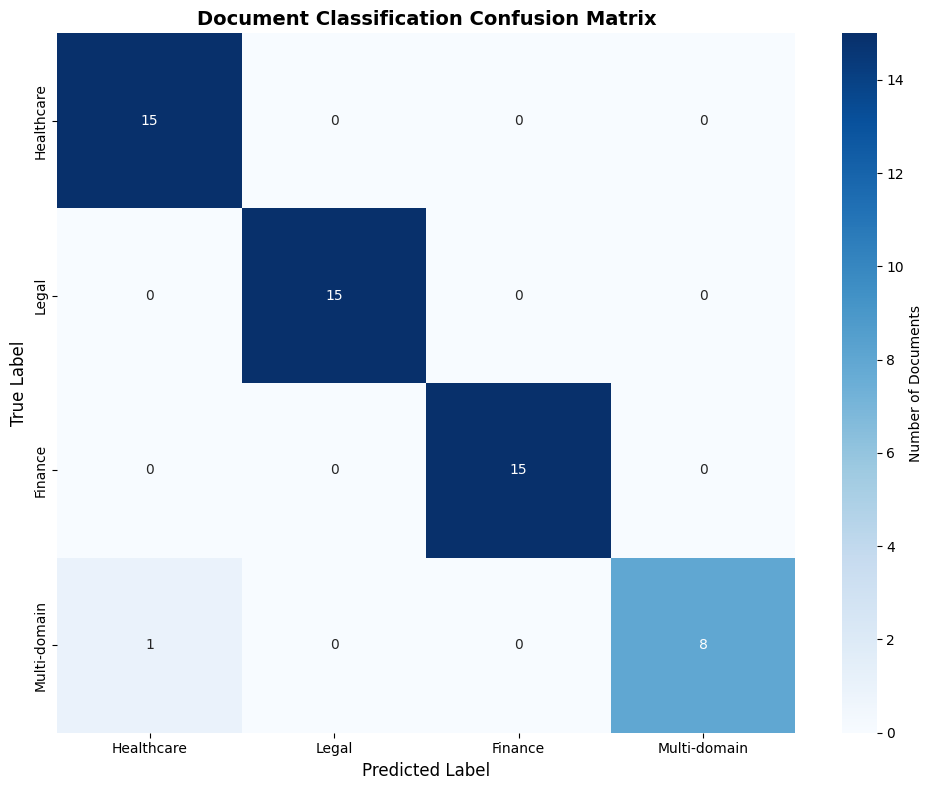

Confusion matrix saved to /content/confusion_matrix.png


In [43]:
# Confusion Matrix Visualization
print("Generating confusion matrix...")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred,
                      labels=['Healthcare', 'Legal', 'Finance', 'Multi-domain'])

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthcare', 'Legal', 'Finance', 'Multi-domain'],
            yticklabels=['Healthcare', 'Legal', 'Finance', 'Multi-domain'],
            cbar_kws={'label': 'Number of Documents'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Document Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/results_from_Task_2B/confusion_matrix2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to /content/confusion_matrix.png")

In [44]:
def extract_healthcare_entities(text):
    """Extract healthcare entities using Task A model"""
    inputs = healthcare_tokenizer(text, return_tensors="pt",
                                   truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = healthcare_model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    tokens = healthcare_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    predicted_labels = [healthcare_model.config.id2label[pred.item()]
                       for pred in predictions[0]]

    entities = []
    current_entity = None

    for token, label in zip(tokens, predicted_labels):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        if label.startswith('B-'):
            if current_entity:
                entities.append(current_entity)
            current_entity = {'text': token.replace('▁', ' ').strip(), 'label': label[2:]}
        elif label.startswith('I-') and current_entity:
            current_entity['text'] += token.replace('▁', ' ')
        elif label == 'O':
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    if current_entity:
        entities.append(current_entity)

    return entities

def extract_legal_entities(text):
    """Extract legal entities using transformer NER"""
    doc = general_nlp(text[:100000])

    relevant_labels = {'PERSON', 'ORG', 'DATE', 'GPE', 'LAW', 'EVENT'}
    entities = [
        {"text": ent.text, "label": ent.label_}
        for ent in doc.ents
        if ent.label_ in relevant_labels
    ]
    return entities

def extract_finance_entities(text):
    """Extract finance entities using transformer NER"""
    doc = general_nlp(text[:100000])

    relevant_labels = {'MONEY', 'ORG', 'PERCENT', 'CARDINAL', 'DATE', 'PERSON'}
    entities = [
        {"text": ent.text, "label": ent.label_}
        for ent in doc.ents
        if ent.label_ in relevant_labels
    ]
    return entities

def extract_entities(text, predicted_class):
    """Extract entities based on predicted document class"""
    entities = {}

    if predicted_class == "Healthcare":
        entities['Healthcare'] = extract_healthcare_entities(text)
    elif predicted_class == "Legal":
        entities['Legal'] = extract_legal_entities(text)
    elif predicted_class == "Finance":
        entities['Finance'] = extract_finance_entities(text)
    elif predicted_class == "Multi-domain":
        entities['Healthcare'] = extract_healthcare_entities(text)
        entities['Legal'] = extract_legal_entities(text)
        entities['Finance'] = extract_finance_entities(text)

    return entities

print("Entity extraction functions defined")

Entity extraction functions defined


In [45]:
# Complete Pipeline Function
def process_document(doc_text, doc_id="unknown"):
    """
    Complete pipeline: Classify → Extract Entities → Return JSON
    """
    # Step 1: Classify document
    doc_vec = vectorizer.transform([doc_text])
    predicted_class = classifier.predict(doc_vec)[0]
    confidence_scores = classifier.predict_proba(doc_vec)[0]
    confidence = confidence_scores.max()

    # Get confidence per class
    class_confidence = dict(zip(classifier.classes_, confidence_scores))

    # Step 2: Extract entities
    entities = extract_entities(doc_text, predicted_class)

    # Step 3: Format output
    output = {
        "document_id": doc_id,
        "predicted_class": predicted_class,
        "confidence": round(float(confidence), 3),
        "class_probabilities": {
            k: round(float(v), 3)
            for k, v in class_confidence.items()
        },
        "entities": entities
    }

    return output

print("Complete pipeline function defined")

Complete pipeline function defined


In [46]:
# Test on Sample Documents
print("\n" + "="*70)
print("TESTING PIPELINE ON SAMPLE DOCUMENTS")
print("="*70)

# Test on a few documents from test set
sample_indices = [0, 10, 20, 30]

for idx in sample_indices:
    test_doc = docs_test[idx]
    result = process_document(test_doc['text'], test_doc['id'])

    print(f"\n--- Document: {result['document_id']} ---")
    print(f"Predicted: {result['predicted_class']} (confidence: {result['confidence']})")
    print(f"True label: {test_doc['label']}")
    print(f"Entities found: {sum(len(ents) for ents in result['entities'].values())}")

    # Show sample entities
    for domain, ents in result['entities'].items():
        if ents:
            print(f"\n  {domain} entities (showing first 3):")
            for ent in ents[:3]:
                print(f"    - {ent['text']} ({ent['label']})")


TESTING PIPELINE ON SAMPLE DOCUMENTS

--- Document: health_3 ---
Predicted: Healthcare (confidence: 0.49)
True label: Healthcare
Entities found: 14

  Healthcare entities (showing first 3):
    - Her (Disease)
    - editary deficiency of the fifth component of complement (Disease)
    - hereditary deficiency of the fifth component of complement (Disease)

--- Document: legal_27 ---
Predicted: Legal (confidence: 0.636)
True label: Legal
Entities found: 50

  Legal entities (showing first 3):
    - 28155/02 (DATE)
    - 28156/02 (DATE)
    - the Republic of Turkey (GPE)

--- Document: finance_28 ---
Predicted: Finance (confidence: 0.547)
True label: Finance
Entities found: 4

  Finance entities (showing first 3):
    - Eulalia F. Valderrama (PERSON)
    - 08/31/202
	917 (DATE)
    - 08/31/2020 08:17 AM (DATE)

--- Document: finance_2 ---
Predicted: Finance (confidence: 0.531)
True label: Finance
Entities found: 1

  Finance entities (showing first 3):
    - 45681 (CARDINAL)


In [47]:
# Generate JSON Outputs for All Test Documents
# ============================================================================
print("\n" + "="*70)
print("GENERATING JSON OUTPUTS FOR ALL TEST DOCUMENTS")
print("="*70)

all_results = []

for doc in docs_test:
    result = process_document(doc['text'], doc['id'])
    result['true_label'] = doc['label']  # Add true label for evaluation
    all_results.append(result)

# Save to file
output_file = '/content/drive/MyDrive/results_from_Task_2B/task_b_results.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Generated {len(all_results)} document outputs")
print(f"Results saved to: {output_file}")

# Show a sample output
print("\n--- Sample JSON Output ---")
print(json.dumps(all_results[0], indent=2))


GENERATING JSON OUTPUTS FOR ALL TEST DOCUMENTS
Generated 54 document outputs
Results saved to: /content/drive/MyDrive/results_from_Task_2B/task_b_results.json

--- Sample JSON Output ---
{
  "document_id": "health_3",
  "predicted_class": "Healthcare",
  "confidence": 0.49,
  "class_probabilities": {
    "Finance": 0.178,
    "Healthcare": 0.49,
    "Legal": 0.142,
    "Multi-domain": 0.19
  },
  "entities": {
    "Healthcare": [
      {
        "text": "Her",
        "label": "Disease"
      },
      {
        "text": "editary deficiency of the fifth component of complement",
        "label": "Disease"
      },
      {
        "text": "hereditary deficiency of the fifth component of complement",
        "label": "Disease"
      },
      {
        "text": "system",
        "label": "Disease"
      },
      {
        "text": "ic lupus erythematosus",
        "label": "Disease"
      },
      {
        "text": "lupus",
        "label": "Disease"
      },
      {
        "text": "C5 defi

In [48]:
# Summary Statistics
print("\n" + "="*70)
print("TASK B SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  - Total documents: {len(all_documents)}")
print(f"  - Training set: {len(X_train)}")
print(f"  - Test set: {len(X_test)}")

print(f"\nClassification Performance:")
print(f"  - Overall Accuracy: {accuracy:.4f}")
print(f"  - Per-class F1 scores:")
from sklearn.metrics import f1_score
for label in ['Healthcare', 'Legal', 'Finance', 'Multi-domain']:
    f1 = f1_score(y_test, y_pred, labels=[label], average='micro')
    print(f"    - {label}: {f1:.4f}")

print(f"\nEntity Extraction:")
total_entities = sum(sum(len(ents) for ents in r['entities'].values())
                    for r in all_results)
print(f"  - Total entities extracted: {total_entities}")
print(f"  - Average entities per document: {total_entities/len(all_results):.1f}")

print(f"\nOutputs:")
print(f"  - Confusion matrix: /content/drive/MyDrive/results_from_Task_2B/confusion_matrix.png")
print(f"  - JSON results: /content/drive/MyDrive/results_from_Task_2B/task_b_results.json")



TASK B SUMMARY

Dataset:
  - Total documents: 180
  - Training set: 126
  - Test set: 54

Classification Performance:
  - Overall Accuracy: 0.9815
  - Per-class F1 scores:
    - Healthcare: 0.9677
    - Legal: 1.0000
    - Finance: 1.0000
    - Multi-domain: 0.9412

Entity Extraction:
  - Total entities extracted: 1215
  - Average entities per document: 22.5

Outputs:
  - Confusion matrix: /content/drive/MyDrive/results_from_Task_2B/confusion_matrix.png
  - JSON results: /content/drive/MyDrive/results_from_Task_2B/task_b_results.json
